## Joplin Tornado Example

Please note that you might need additional dependencies to run this notebook, such as [geopandas](https://anaconda.org/conda-forge/geopandas) and [contextily](https://anaconda.org/conda-forge/contextily)

- Tornadoes occur at a high frequency in the United States compared with other natural hazards such as earthquakes and tsunamis but have a substantially smaller footprint. Even a single high-intensity tornado can result in high casualty rates and catastrophic economic losses and social consequences, particularly for small to medium communities.

- The city of Joplin, Missouri, USA, was hit by an EF-5 tornado on May 22, 2011.  The National Institute of Standards and Technology (NIST) conducted a technical investigation of this devastating event which can be found at: https://nvlpubs.nist.gov/nistpubs/NCSTAR/NIST.NCSTAR.3.pdf .  The Center for Risk-Based Community Resilience Planning  simulated this event for buildings and the electrical power network of Joplin in IN-CORE.  This Juypter Notebook provides an example of how to use IN-CORE.

- The initial damage prediction utilized the tornado path, tornado fragility curves representative of a 19- archetype building dataset, and EPN datasets.  Generic tornado paths are also available in IN-CORE, or a user defined tornado path is possible. 

- The functionality of the infrastructure was linked with a computable general equilibrium (CGE) economics model that computes specific community resilience metrics in economic terms.  A population dislocation model provides resilience metrics related to socio-demographics such as population dislocation as a function of income or race/ethnicity.

- This example demonstrates how users interact with the IN-CORE computational environment.

*This notebook was created by Lisa Wang, supervised by Professor John W. van de Lindt, with the help of the NCSA team (Jong Sung Lee, Chris Navarro, Diego Calderon, Chen Wang, Michal Ondrejcek, Gowtham Naraharisetty, and Yong Wook Kim). The population disclocation model was developed by Nathanael Rosenheim and the CGE model portion provided by Brad Hartman under the supervision of Professor Harvey Cutler.

### Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**. 

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>0.5.3 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| geopandas | 0.6.2 | used for working with geospatial data | 
| matplotlib | 3.1.2 | used for plotting results |
| contextily | 0.99.0 | used for context geo-tiles |
| descartes | 1.1.0 | used for visualization of geometric objects as matplotlib paths |

Economic Computable General Equilibrium (CGE) Model uses the ipopt solver. There is an optional `solver_path` variable where the user may specify the absolute path to the ipopt they wish to use. The ipopt solver is installed with pyIncore, so the environment should have the solver in it, but the variable lets the user specify a version elsewhere when desired. 
If not specified, then the ipopt that is in the current environment is used. To know the absolute path of the ipopt solver in your local machine, open a terminal window, activate your **pyIncore** environment, and run the following command according to your OS:

- on Mac: open a terminal window, activate your conda environment and type `which ipopt`. 
- on Windows: open a command terminal, activate your conda environment and type `whereipopt`.

and paste the path (e.g. on Mac OS `/Users/<user>/opt/miniconda3/envs/<environment>/bin/ipopt`) below:

In [1]:
solver_path = "ipopt"

### 1. Hazard, Data, and Fragility

This section introduces the input for the infrastructure damage analysis including the tornado path, building dataset, and building fragility curves for tornado.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt  # This cell is used to import python libraries to visualize the analysis outputs.
import matplotlib.image as mpimg
import geopandas as gpd
import pandas as pd
import numpy as np
import contextily as ctx

#### 1.1. Tornado Path

This figure shows the 2011 Joplin tornado path with EF zones provided in the legend. The tornado path represents the wind speed within the vortex (multi-vortex in the case of Joplin) that was estimated to have EF5 wind speeds of more than 200 mph, reducing to EF4 wind speeds as the areas move outward from the vortex, and eventually reaching EF1 zone. (Attary et al. 2018)

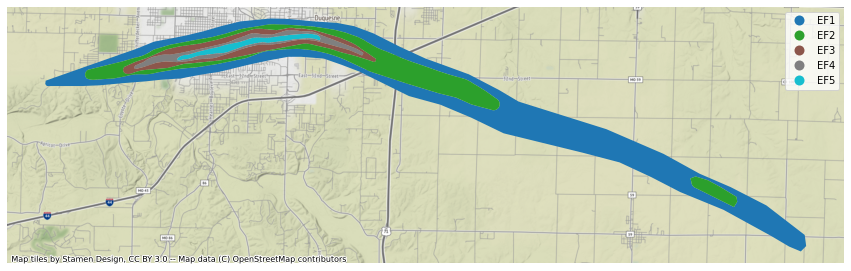

In [3]:
path = Path('5d07cbe9b9219c065b819103/joplin_path_wgs84.shp')
shp_path = Path(path)
tornado = gpd.read_file(shp_path)
tornado = tornado.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(15, 7))
tornado.plot(column='ef_rating', categorical=True,legend=True,ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()

#### 1.2. Building Archetypes

The 19 archetype buildings are used herein to represent the Joplin community. The selected building archetypes consider building characteristics such as footprint area, roof structure, number of stories, and so on. (Attary et al. 2018, Memari et al. 2018)

Joplin building archetypes as they appear in GIS software such as QGIS.

<img src="Images/Joplin_building_archetypes.png" alt="Joplin building archetypes" style="width: 850px; height: 500px;" />

The same layout of the building dataset visualized with Python library.

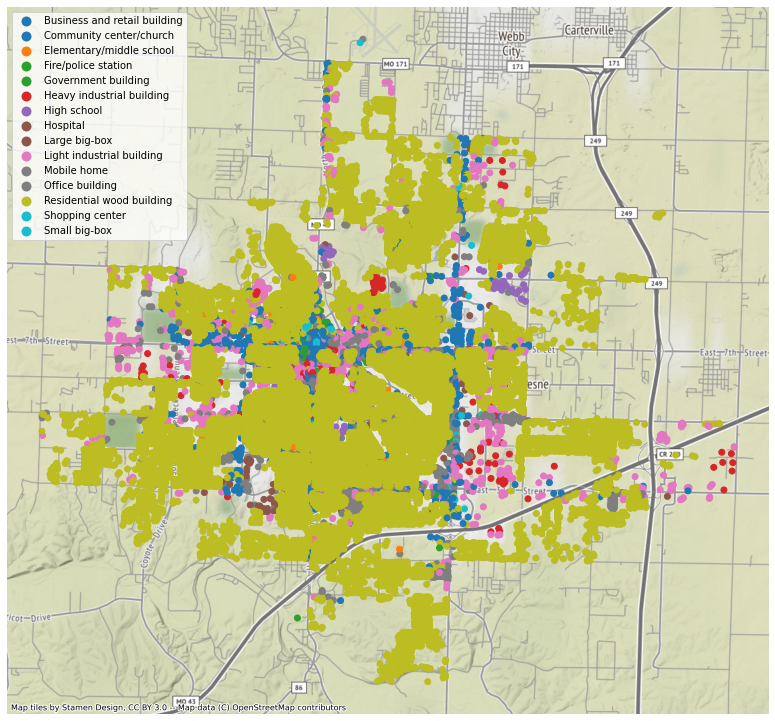

In [4]:
shp_path = Path('joplin_bldg_inventory_v6_LW/joplin_bldg_inventory_v6.shp')
blgs = gpd.read_file(shp_path)
blgs = blgs.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(16, 13))
blgs.plot(column='types', categorical='True', legend='True',ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()

#### 1.3. Fragility Curves

There 19 fragility curves set for these 19 building types in the four damage states, which covers the entire range of wind speeds associated with tornadoes (Attary et al. 2018, Memari et al. 2018). Below we selected 3 types to plot as examples.

In [5]:
from pyincore import IncoreClient
from pyincore import FragilityService, MappingSet
from pyincore_viz.plotutil import PlotUtil as plot
from pyincore.models.fragilitycurveset import FragilityCurveSet

client = IncoreClient()  # The authentication service validates username/password and  
                         # approves users to access to other services.

Connection successful to IN-CORE services. pyIncore version detected: 0.8.0


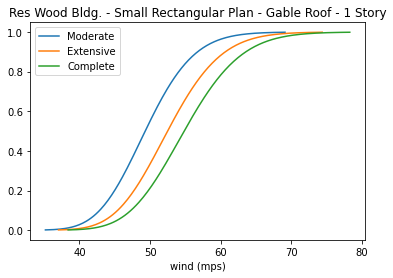

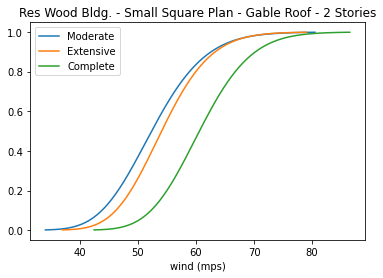

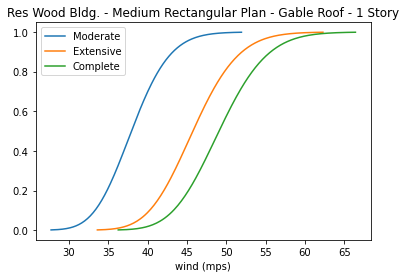

In [6]:
fragility_service = FragilityService(client)
mapping_id = "5d8942dfb9219c068ea795ea"
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

# plot fragility for the first 3 archetypes using pyincore viz method
for mapping in mapping_set.mappings[:3]:
    fragility_id = mapping.entry['Non-Retrofit Fragility ID Code']
    fragility_set = FragilityCurveSet(fragility_service.get_dfr3_set(fragility_id))
    plt = plot.get_fragility_plot(fragility_set)
    plt.show()

### 2. Infrastructure Damage Analysis

The models in this section implement the prediction of community-level damage to the buildings and Electric Power Network (EPN) for the 2011 Joplin tornado.

In [7]:
hazard_type = "tornado"
hazard_id = "5d07cbeab9219c065b080930"  # The simulated EF-5 tornado shows geographical locations and the range
                                        # of wind speed of tornado hazard in Joplin.

#### 2.1. Buildings Damage

In [8]:
from pyincore.analyses.buildingdamage import BuildingDamage  # Import building damage module integrated into pyIncore.

In [9]:
bldg_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset, which is a package of GIS files.
mapping_id = "5d8942dfb9219c068ea795ea"       # Create a mapping to assign tornado fragilities to 19 building archetypes.

fragility_service = FragilityService(client)  # loading fragility mapping
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

bldg_dmg = BuildingDamage(client) 

building_inv = bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [10]:
result_name = "Joplin_bldg_dmg_result"  
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)  # Define the result name, etc., and choose the number of CPU locally 
                                      # to run the model parallelly.

True

In [11]:
bldg_dmg.run_analysis()  # Run the building damage module to get building damage results for Joplin in a .csv file format. 
                         # The building damage results herein are referred to fragilities at three damage states (moderate, 
                         # heavy, complete) for 28152 buildings located in Joplin that fall within the tornado path or not.
building_dmg_result = bldg_dmg.get_output_dataset('result')

# Convert dataset to Pandas DataFrame
df = building_dmg_result.get_dataframe_from_csv()
# Display top 5 rows of output data
df.head()

,guid,immocc,lifesfty,collprev,insignific,moderate,heavy,complete,demandtype,demandunits,hazardval
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0


#### 2.2. Electrical Power Facility (EPF) - Substations Damage

In [12]:
from pyincore.analyses.epfdamage.epfdamage import EpfDamage # Import epf damage module integrated into pyIncore.

In [13]:
epf_substations_id = "5d92355bb9219c06ae7e386a"  
mapping_id = "5d8a326fb9219c068ea798e7"  # Create a mapping to assign tornado fragilities to substations.

fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

epf_sub_dmg = EpfDamage(client)  

epf_sub_dmg.load_remote_input_dataset("epfs", epf_substations_id) 
                               # Load the Joplin substations dataset, which is a package of GIS files.
epf_sub_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [14]:
result_name = "Joplin_epf_substations_dmg_result"
epf_sub_dmg.set_parameter("result_name", result_name)
epf_sub_dmg.set_parameter("hazard_type", hazard_type)
epf_sub_dmg.set_parameter("hazard_id", hazard_id)
epf_sub_dmg.set_parameter("num_cpu", 4)
epf_sub_dmg.set_parameter("fragility_key", "substations")  # Define the result name, etc., and choose the number
                                                           # of CPU locally to run the model parallelly.

True

In [15]:
epf_sub_dmg.run_analysis()  # Run the EPF damage module to get substations damage results for Joplin in a .csv file format. The 
                            # substations damage results herein are referred to fragilities at four damage states (insignificant, 
                            # moderate, extensive, complete) for 18 substations located in Joplin that fall within the tornado 
                            # path or not.
substation_dmg_result = epf_sub_dmg.get_output_dataset('result')

df = substation_dmg_result.get_dataframe_from_csv()
df.head()

,guid,ls-slight,ls-moderat,ls-extensi,ls-complet,ds-none,ds-slight,ds-moderat,ds-extensi,ds-complet,demandtype,demandunits,hazardtype,hazardval
0,7f426763-81c6-4cac-b98d-c37a5e439b90,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
1,fc8add00-6760-4752-b1fb-7d6ca813f535,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
4,eb4ce929-5164-4ebf-ace2-708096d89db5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0


#### 2.3. Electrical Power Facility (EPF) - Poles Damage

In [16]:
epf_poles_id = "5d923daab9219c06ae84afb0"  # Load the Joplin poles dataset, which is a package of GIS files.
mapping_id = "5d8a326fb9219c068ea798e7"    # Create a mapping to assign tornado fragilities to poles.

fragility_service = FragilityService(client)        # loading fragility mapping
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

epf_poles_dmg = EpfDamage(client) 

epf_poles_dmg.load_remote_input_dataset("epfs", epf_poles_id)

epf_poles_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

True

In [17]:
result_name = "Joplin_epf_poles_dmg_result"
epf_poles_dmg.set_parameter("result_name", result_name)
epf_poles_dmg.set_parameter("hazard_type", hazard_type)
epf_poles_dmg.set_parameter("hazard_id", hazard_id)
epf_poles_dmg.set_parameter("num_cpu", 4)
epf_poles_dmg.set_parameter("fragility_key", "poles")  # Define the result name, etc., and choose the number
                                                       # of CPU locally to run the model parallelly.

True

In [18]:
epf_poles_dmg.run_analysis()  # Run the EPF damage module to get poles damage results for Joplin in a .csv file 
                              # format. The poles damage results herein are referred to fragilities at four 
                              # damage states (insignificant, moderate, extensive, complete) for 23857 poles 
                              # located in Joplin that fall within the tornado path or not.
pole_dmg_result = epf_poles_dmg.get_output_dataset('result')


df = pole_dmg_result.get_dataframe_from_csv()
df.head()

,guid,ls-slight,ls-moderat,ls-extensi,ls-complet,ds-none,ds-slight,ds-moderat,ds-extensi,ds-complet,demandtype,demandunits,hazardtype,hazardval
0,cffe8f2e-9887-456b-9625-5ed122b68c45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
1,54efa7ba-475f-4b1d-8821-42d156cb3f7d,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
2,d0f52ad0-1187-4c0d-9a72-c02687c19778,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
3,901ae6cb-01d5-4936-a3fe-729d930e76ab,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0
4,958d0146-1dd5-4b10-8d16-9ec44e7b3010,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,wind,mps,tornado,0.0


### 3. Monte Carlo Simulation (MCS)

Researchers can use Monte Carlo Simulation to estimate the probability of each building being in a particular damage state.  This example uses 500 iterations to determine the failure probability of buildings reaching damage state 2, damage state 3, and damage state 4. Users can run 10000 samples or even more for a more accurate Monte Carlo Simulation to determine the building failure probabilities.  Note that this takes several minutes and we are working on developing a more efficient algorithm.

In [19]:
num_samples = 500

#### 3.1. MCS chaining with Joplin building damage

In [20]:
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
                                                  # Import Monte Carlo failure probability module integrated into pyIncore.

In [21]:
mc_bld = MonteCarloFailureProbability(client)

mc_bld.set_input_dataset("damage", building_dmg_result)  #  Load the Joplin building damage results dataset 
                                                         # generated from the previous model as an input
mc_bld.set_parameter("num_cpu", 8)
mc_bld.set_parameter("num_samples", num_samples)
mc_bld.set_parameter("damage_interval_keys", ["insignific", "moderate", "heavy", "complete"])
mc_bld.set_parameter("failure_state_keys", ["moderate", "heavy", "complete"])

mc_bld.set_parameter("result_name", "tornado_mc_failure_probability_buildings") # name of csv file with results

True

In [22]:
mc_bld.run_analysis()  # Run the Monte Carlo Simulation module to obtain the building failure probabilities. The building failure
                       # probabilities herein only consider the physical damage without the interdependency.

building_failure_probability = mc_bld.get_output_dataset('failure_probability')  # get buildings failure probabilities

df = building_failure_probability.get_dataframe_from_csv()
df.head()

,guid,immocc,lifesfty,collprev,insignific,moderate,heavy,complete,demandtype,demandunits,hazardval,failure_probability
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0,0.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0,0.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0,0.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0,0.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Wind,mps,0.0,0.0


In [23]:
building_damage_mcs_samples = mc_bld.get_output_dataset('sample_failure_state')  # get buildings failure states

bdmcs = building_damage_mcs_samples.get_dataframe_from_csv()
bdmcs.head()

,guid,failure
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


#### 3.2. MCS chaining with Joplin EPF substations damage

In [24]:
mc_sub = MonteCarloFailureProbability(client)

mc_sub.set_input_dataset("damage", substation_dmg_result)
mc_sub.set_parameter("num_cpu", 8)
mc_sub.set_parameter("num_samples", num_samples)
mc_sub.set_parameter("damage_interval_keys", ["ds-none","ds-slight","ds-moderat","ds-extensi","ds-complet"])
mc_sub.set_parameter("failure_state_keys", ["ds-slight", "ds-moderat", "ds-extensi", "ds-complet"])

mc_sub.set_parameter("result_name", "Joplin_mcs_substations_samples") # name of csv file with results

True

In [25]:
mc_sub.run_analysis()

substation_damage_mcs_samples = mc_sub.get_output_dataset('sample_failure_state')

sdmcs = substation_damage_mcs_samples.get_dataframe_from_csv()
sdmcs.head()

,guid,failure
0,7f426763-81c6-4cac-b98d-c37a5e439b90,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,fc8add00-6760-4752-b1fb-7d6ca813f535,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,e8f4939d-763f-4743-bc61-c23e0b8e0f7a,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,2cab48ff-c5ce-495e-9662-67c9a177efc4,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,eb4ce929-5164-4ebf-ace2-708096d89db5,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


#### 3.3. MCS chaining with Joplin EPF poles damage

In [26]:
mc_pole = MonteCarloFailureProbability(client)

mc_pole.set_input_dataset("damage", pole_dmg_result)
mc_pole.set_parameter("num_cpu", 8)
mc_pole.set_parameter("num_samples", num_samples)
mc_pole.set_parameter("damage_interval_keys", ["ds-none","ds-slight","ds-moderat","ds-extensi","ds-complet"])
mc_pole.set_parameter("failure_state_keys", ["ds-slight", "ds-moderat", "ds-extensi", "ds-complet"])

mc_pole.set_parameter("result_name", "Joplin_mcs_poles_samples") # name of csv file with results

True

In [27]:
mc_pole.run_analysis()

pole_damage_mcs_samples = mc_pole.get_output_dataset('sample_failure_state')

pdmcs = pole_damage_mcs_samples.get_dataframe_from_csv()
pdmcs.head()

,guid,failure
0,cffe8f2e-9887-456b-9625-5ed122b68c45,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,54efa7ba-475f-4b1d-8821-42d156cb3f7d,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,d0f52ad0-1187-4c0d-9a72-c02687c19778,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,901ae6cb-01d5-4936-a3fe-729d930e76ab,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,958d0146-1dd5-4b10-8d16-9ec44e7b3010,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


#### 3.4. Building Damage Spatial Distribution Results

Joplin building failure probability map as it appears in GIS software such as QGIS.

<img src="Images/Building_damage_spatial_results.png" alt="Building damage spatial results" style="float: left; width: 850px; height: 500px;" />

The same layout of the building dataset visualized with Python library.

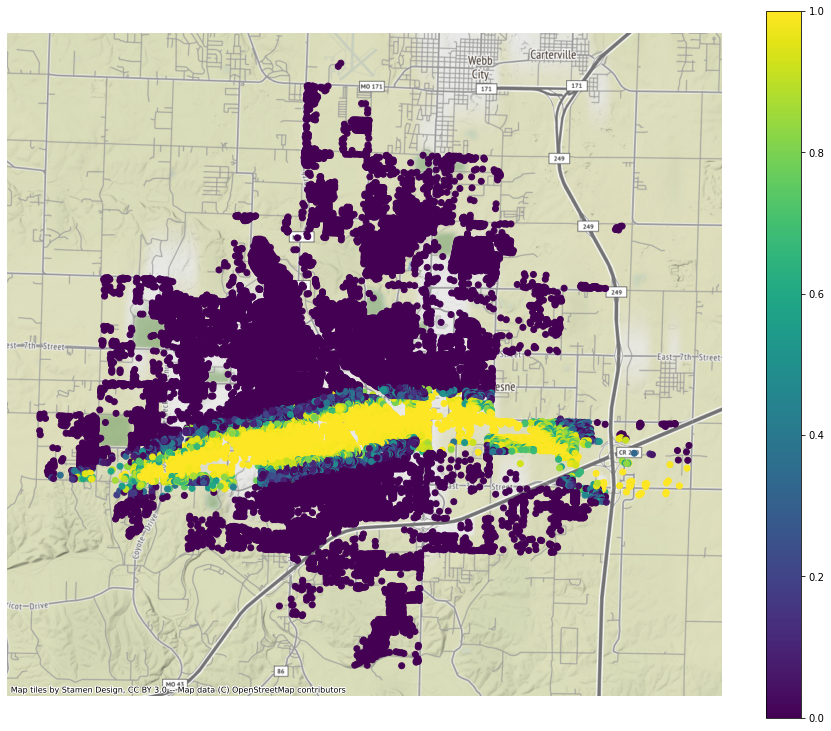

In [28]:
blgs = gpd.read_file(shp_path)
blgs = blgs.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(16, 13))
blgs.plot(column='failure',legend='True',ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()   # The layout of the building damage spatial distribution results shown in Python.

### 4. Infrastructure Functionality Analysis

The functionality analysis module below can be used to calculate building functionality probabilities considering two situations: buildings are in at least a damage state 2 or greater or buildings are not damaged but electric power is not available to the building. Whether buildings can receive electrical power is assumed to depend on the interdependency between buildings and substations, and between buildings and poles in close proximity. If both the nearest pole to the building and the substation where buildings belong to its service area are functional, buildings are considered to be able to receive electric power.

#### 4.1. Building Functionality Probability

In [29]:
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
                                            # Import building functionality module integrated into pyIncore.

In [30]:
bldg_func = BuildingFunctionality(client)

# Load the datasets of building samples, substation samples, and pole samples. All of the samples are randomly 
# generated using the Monte Carlo Simulation module introduced in the previous section.
bldg_func.set_input_dataset("building_damage_mcs_samples", building_damage_mcs_samples)
bldg_func.set_input_dataset("substations_damage_mcs_samples", substation_damage_mcs_samples)
bldg_func.set_input_dataset("poles_damage_mcs_samples", pole_damage_mcs_samples)

# Load the dataset of the interdependency table between buildings and substations, and between buildings and poles.
interdependency_id = "5dcf4a34b9219ca5e4118312"
bldg_func.load_remote_input_dataset("interdependency_dictionary", interdependency_id)

bldg_func.set_parameter("result_name", "Joplin_mcs_functionality_probability")

True

In [31]:
bldg_func.run_analysis()  # Run the module to obtain the building functionality probabilities.

bldg_func_probability = bldg_func.get_output_dataset('functionality_samples')

df_building_func = bldg_func_probability.get_dataframe_from_csv()
df_building_func.head()

,building_guid,samples
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
2,758fb3de-108a-4e04-895e-fdc4b8627876,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
3,7b706697-bf9b-4883-90f6-862d67a8e64b,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,"1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,..."


#### 4.2. Building Functionality Spatial Distribution Results

Joplin building functionality map as it appears in GIS software.

<img src="Images/Building_functionality_spatial_results.png" alt="Building functionality spatial results" style="float: left; width: 850px; height: 500px;" />

The same layout of the building functionality dataset visualized with Python library.

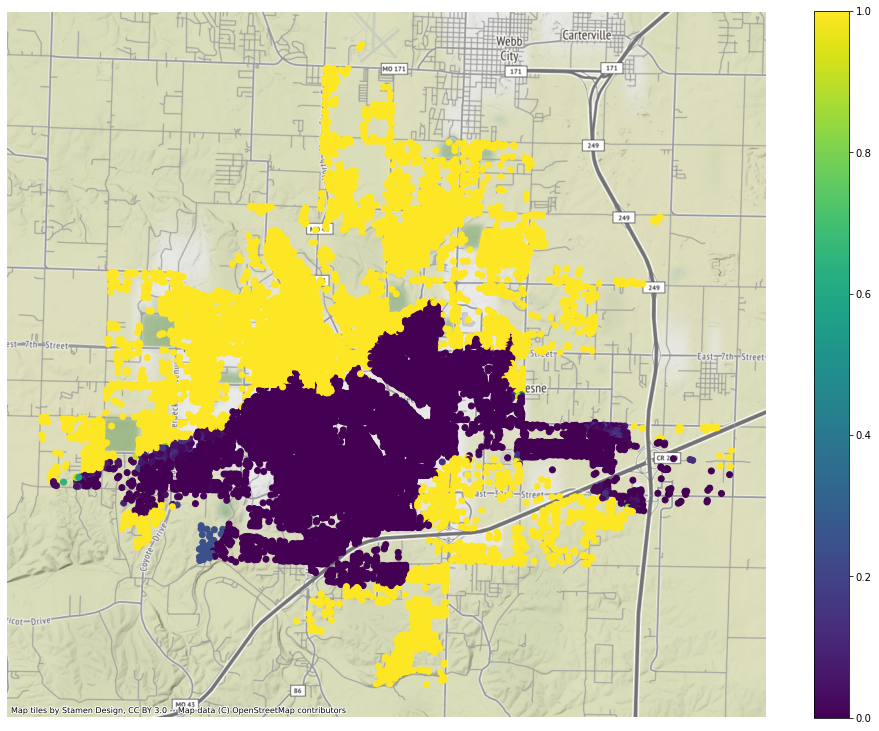

In [32]:
blgs = gpd.read_file(shp_path)
blgs = blgs.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(17, 13))
blgs.plot(column='fun',legend='True',ax=ax)
ctx.add_basemap(ax)
ax.set_axis_off()

plt.show()   # The layout of the building functionality spatial distribution results shown in Python.

##### 4.3. Physical Service Resilience Metrics

After finding the damage level for each component (buildings, substations, and poles) based on the components' fragility curves, their intrinsic failure status is expressed as a binary format with either failed (0) or not-failed (1). Then the failure status of all the buildings is updated by considering their dependencies with the corresponding electric power facilities. Each component generates 500 samples randomly with their failure status determined, and the percentage of building functional and nonfunctional could be calculated using the updated status of the same sample (such as sample #1) for all the buildings, illustrated herein as an example.

The percent shown in the horizontal bar below refers to the number of nonfunctional/damaged buildings divided by all buildings in Joplin. For example, the mean percentage of building nonfunctional is around 52%, and the standard deviation percentage shown as an error bar. The percentage is two times more than the percent of building in damage is because three substations fall within the tornado path. Consequently, there is a significant probability for buildings located in their service area cannot be available to access the electric power even though some buildings themselves are still safe and operational in the immediate response of the tornado hazard. It is worthy to note that a random tornado path analysis will produce a larger standard deviation of building damage and building functionality.

Calculate and show all three infrustructure damages and resulting total building funcionality.

In [33]:
import numpy as np
import pandas as pd

# buildings damage
bdm = bdmcs["failure"].str.split(pat=",")
# strings to integers, change fail to 1
bdm = 1 - bdm.apply(pd.to_numeric)
# convert panda frame to numpy ndarray and do the statistics
bdm = bdm.to_numpy()
# convert list of np arrays into single one
bdm = np.stack(bdm)
# percent
bdm_guid = 100 * bdm.mean(axis=0)
bdm_mean = np.mean(bdm_guid)
bdm_std = np.std(bdm_guid)

# substations damage
sdm = sdmcs["failure"].str.split(pat=",")
sdm = 1 - sdm.apply(pd.to_numeric)
sdm = sdm.to_numpy()
sdm = np.stack(sdm)
sdm_guid = 100 * sdm.mean(axis=0)
sdm_mean = np.mean(sdm_guid)
sdm_std = np.std(sdm_guid)

# poles damage
pdm = pdmcs["failure"].str.split(pat=",")
pdm = 1 - pdm.apply(pd.to_numeric)
pdm = pdm.to_numpy()
pdm = np.stack(pdm)
pdm_guid = 100 * pdm.mean(axis=0)
pdm_mean = np.mean(pdm_guid)
pdm_std = np.std(pdm_guid)

# buildings combined functionality
bfm = df_building_func["samples"].str.split(pat=",")
bfm = 1 - bfm.apply(pd.to_numeric)
bfm = bfm.to_numpy()
bfm = np.stack(bfm)
bfm_guid = 100 * bfm.mean(axis=0)
bfm_mean = np.mean(bfm_guid)
bfm_std = np.std(bfm_guid)

In [34]:
# dataframe from statistical results
infra = ('Percent of building nonfunctional', 'Percent of building in damage', 'Percent of substation in damage',\
         'Percent of pole in damage')
res_data = {"infrastructure": infra,
            "percentage": [np.round(bfm_mean, 2), np.round(bdm_mean, 2), 
                           np.round(sdm_mean, 2), np.round(pdm_mean, 2)],
            "std": [np.round(bfm_std, 2), np.round(bdm_std, 2), 
                    np.round(sdm_std, 2), np.round(pdm_std, 2)]}
func_data = pd.DataFrame(res_data)
print(func_data)

                      infrastructure  percentage   std
0  Percent of building nonfunctional       52.07  0.05
1      Percent of building in damage       19.17  0.09
2    Percent of substation in damage       15.73  2.08
3          Percent of pole in damage       15.73  0.01


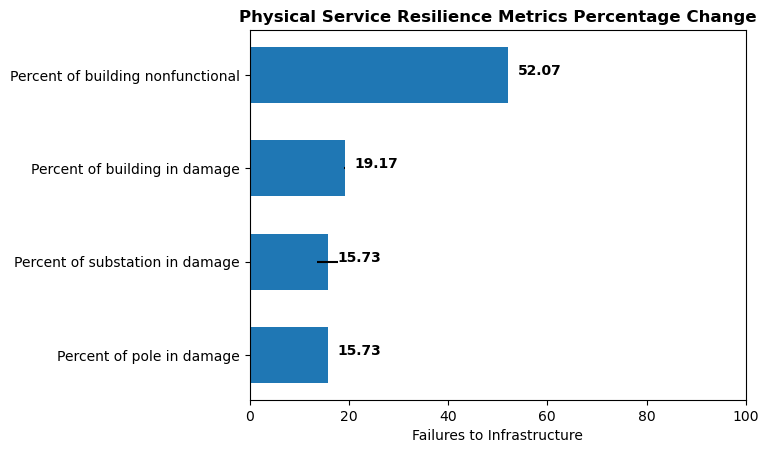

In [35]:
plt.rcdefaults()
fig, ax = plt.subplots()

y_pos = np.arange(len(infra))
performance = res_data['percentage']

for i, v in enumerate(performance):
    ax.text(v + 2, i, str(v), color='black', fontweight='bold')
    
ax.barh(y_pos, performance, xerr=res_data['std'], align='center', height=0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(infra)
ax.invert_yaxis()
ax.set_xlabel('Failures to Infrastructure')
ax.set_title('Physical Service Resilience Metrics Percentage Change',fontsize = 12,weight='bold')
plt.xlim(0, 100)
plt.show()  # Physical service resilience metrics percentage change immediately after the simulated EF-5 tornado.

### 5. Economic analysis

#### 5.1. Computable General Equilibrium (CGE) Model

A computable general equilibrium (CGE) model is based on fundamental economic principles. A CGE model uses multiple data sources to model the interactions of households, firms and relevant government entities as they contribute to economic activity. The model is based on (1) utility-maximizing households that supply labor and capital, using the proceeds to pay for goods and services (both locally produced and imported) and taxes;
(2) the production sector, with perfectly competitive, profit-maximizing firms using intermediate inputs, capital, land and labor to produce goods and services for both domestic consumption and export; (3) the government sector that collects taxes and uses tax revenues in order to finance the provision of public services; and (4) the rest of the world.

##### 5.1.2. Capital stock shock analysis

The first step is to aggregate building functionality states and calculates total capital shock losses per sector. We use results of building failure probabilities obtained in previous **MCS chaining with Joplin building damage** section.

In [36]:
from pyincore.analyses.capitalshocks import CapitalShocks

In [37]:
# Joplin building to sector mapping table
building_to_sectors_id = "5f202d674620b643d787a5e7"

In [38]:
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)

# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
# Set datasets
# Joplin building inventory
capital_shocks.load_remote_input_dataset("buildings", bldg_dataset_id)
# Joplin building failure probability
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [39]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

,sector,shock
0,HS1,0.758795
1,HS2,0.754290
2,GOODS,0.812530
3,OTHER,0.830767
4,TRADE,0.837845
5,HS3,0.573029


##### 5.1.3. CGE Model

In [40]:
from pyincore.analyses.joplincge import JoplinCGEModel

Each of the objects with string IDs below refer to datasets used as inputs in the CGE model.

In [41]:
# SAM
# Social accounting matrix (SAM) contains data for firms, households and government which are organized 
# in a way to represent the interactions of all three entities in a typical economy
SAM = "5dd85ae7b9219c06d4da8de4"

# CAPITAL COMP
# BB is a matrix which describes how investment in physical infrastructure is transformed into functioning capital such as commercial and residential buildings. 
# These data are collected from the Bureau of Economic Analysis (BEA).
BB = "5dc1e620b9219c06dd2f473a"

# MISC TABLES
IOUT = "5dc1e6d8b9219c06dd2f475e"  # This is matrix that describes the transfer of tax revenue collected by the local government to help finance local government expenditures. 
MISC = "5dc1e736b9219c06dd2f4782"  # This is the name of a file that contains data for commercial sector employment and physical capital. It also contains data for the number of households and working households in the economy. 
MISCH = "5dc1e7b5b9219c06dd2f47a6"  # A file that contains elasticities for the supply of labor with respect to paying income taxes.
LANDCAP = "5dc1e810b9219c06dd2f47ca"  # Contains information regarding elasticity values for the response of changes in the price of physical capital with respect to the supply of investment.
EMPLOY = "5dc1e85ab9219c06dd2f47ee"  # Table name containing data for commercial sector employment.
IGTD = "5dc1e895b9219c06dd2f4812"  # This variable represents a matrix describing the transfer of taxes collected to a variable which permits governments to spend the tax revenue on workers and intermediate inputs.
TAUFF = "5dc1e8eeb9219c06dd2f4836"  # Represents social security tax rates
JOBCR = "5dc1e962b9219c06dd2f487e"  # This is a matrix describing the supply of workers coming from each household group in the economy. 
OUTCR = "5dc1e9aeb9219c06dd2f48bc"  # This a matrix describing the number of workers who live in Joplin but commute outside of town to work.
sector_shocks = "5f21d40d4620b643d78bb4c2"# This is the aggregation of building functionality states to capital shocks per sector.

In [42]:
# Create Joplin CGE Model
joplin_cge = JoplinCGEModel(client)

In [43]:
# Load analysis input datasets
joplin_cge.load_remote_input_dataset("SAM", SAM)
joplin_cge.load_remote_input_dataset("BB", BB)
joplin_cge.load_remote_input_dataset("IOUT", IOUT)
joplin_cge.load_remote_input_dataset("MISC", MISC)
joplin_cge.load_remote_input_dataset("MISCH", MISCH)
joplin_cge.load_remote_input_dataset("LANDCAP", LANDCAP)
joplin_cge.load_remote_input_dataset("EMPLOY", EMPLOY)
joplin_cge.load_remote_input_dataset("IGTD", IGTD)
joplin_cge.load_remote_input_dataset("TAUFF", TAUFF)
joplin_cge.load_remote_input_dataset("JOBCR", JOBCR)
joplin_cge.load_remote_input_dataset("OUTCR", OUTCR)

# Set analysis input dataset from previous Capital stock shock analysis
joplin_cge.set_input_dataset("sector_shocks", sector_shocks_result)

True

The ipopt solver is installed with pyIncore, so the environment should have the solver in it, but the solver_path variable lets the user specify a version elsewhere when desired. The variable points to the absolute path for where the ipopt solver is installed. To know the absolute path of the ipopt solver in your local machine, open a terminal window, activate your **pyIncore** environment, and run the following command according to your OS:

- on Mac: open a terminal window, activate your conda environment and type "which ipopt". 
- on Windows: open a command terminal, activate your conda environment and type "whereipopt".

and set the path (e.g. on Mac OS `/Users/<user>/opt/miniconda3/envs/<environment>/bin/ipopt`) in `solver_path` variable in Prerequisits or paste it below:

In [44]:
# Set analysis parameters
joplin_cge.set_parameter("solver_path", "ipopt")
joplin_cge.set_parameter("model_iterations", 1)

True

In [45]:
# Run Joplin CGE model analysis
joplin_cge.run_analysis()

Invalid executable path, please make sure you have Pyomo installed.
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Too few degrees of freedom (n_x = 490, n_c = 528).
  Trying fixed_variable_treatment = RELAX_BOUNDS

Number of nonzeros in equality constraint Jacobian...:     2890
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     3366

Total number of variables............................:      687
                     variabl

Objective...............:  -1.6471665696089890e+03   -1.6471665696089890e+03
Dual infeasibility......:   1.7024457124623332e-12    1.7024457124623332e-12
Constraint violation....:   5.8207660913467407e-11    5.8207660913467407e-11
Complementarity.........:   4.9756091166422168e-09    4.9756091166422168e-09
Overall NLP error.......:   4.9756091166422168e-09    4.9756091166422168e-09


Number of objective function evaluations             = 15
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 15
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 13
Total CPU secs in IPOPT (w/o function evaluations)   =      0.034
Total CPU secs in NLP function evaluations           =      0.003

EXIT: Optimal Solution Found.
Ipopt 3.13.2: warm_start_init_point=yes
warm_s

True

In [46]:
# Retrieve result datasets
domestic_supply = joplin_cge.get_output_dataset('domestic-supply')
ds = domestic_supply.get_dataframe_from_csv()
ds.head(6)

,Sectors,DS0,DSL
0,Goods,682.797727,649.766771
1,Trades,229.636282,185.390609
2,Others,266.695641,212.709716
3,HS1,22.018314,13.957562
4,HS2,1361.165027,1285.046878
5,HS3,477.922693,448.089058


In [47]:
gross_income = joplin_cge.get_output_dataset('gross-income')
gi = gross_income.get_dataframe_from_csv()
gi.head()

,Household Group,Y0,YL
0,HH1,12.952321,12.970329
1,HH2,153.488817,151.116947
2,HH3,453.061446,440.305402
3,HH4,438.858832,413.014815
4,HH5,125.028152,121.745674


In [48]:
pre_factor_demand = joplin_cge.get_output_dataset('pre-disaster-factor-demand')
pre_fd = pre_factor_demand.get_dataframe_from_csv()
pre_fd.head()

,Labor Group,GOODS,TRADE,OTHER
0,L1,449.006038,2729.055379,6306.146353
1,L2,3282.049564,4360.095686,12396.308192
2,L3,3013.051661,1851.044407,5444.146479


In [49]:
post_factor_demand = joplin_cge.get_output_dataset('post-disaster-factor-demand')
pos_fd = post_factor_demand.get_dataframe_from_csv()
pos_fd.head()

,Labor Group,GOODS,TRADE,OTHER
0,L1,438.917565,2585.934085,6025.381585
1,L2,3195.133235,4114.472650,11795.760136
2,L3,2919.025274,1738.290821,5155.262801


In [50]:
household_count = joplin_cge.get_output_dataset('household-count')
hc = household_count.get_dataframe_from_csv()
hc.head()

,Household Group,HH0,HHL
0,HH1,3611.010342,3588.283168
1,HH2,5997.031159,5930.188044
2,HH3,7544.090149,7325.858803
3,HH4,2394.098104,2204.757310
4,HH5,793.009003,765.938682


#### 5.2. Economic Resilience Metrics

##### 5.2.1. Percent Reduction of  Domestic Supply

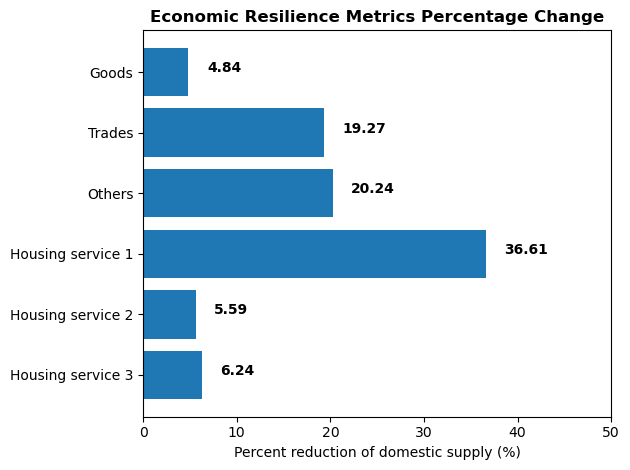

In [51]:
plt.rcdefaults()
fig_ds, ax_ds = plt.subplots()

sectors_ds = ('Goods', 'Trades', 'Others', 'Housing service 1', 'Housing service 2', 'Housing service 3')
y_pos_ds = np.arange(len(sectors_ds))
perf_ds = (1 - ds['DSL'] / ds['DS0']) * 100  # percentage

for i, v in enumerate(round(perf_ds, 2)):
    ax_ds.text(v + 2, i, str(v), color='black', fontweight='bold')
ax_ds.barh(y_pos_ds, perf_ds, align='center', height=0.8)
ax_ds.set_yticks(y_pos_ds)
ax_ds.set_yticklabels(sectors_ds)
ax_ds.invert_yaxis()
ax_ds.set_title('Economic Resilience Metrics Percentage Change', fontsize=12, weight='bold')
ax_ds.set_xlabel('Percent reduction of domestic supply (%)')
plt.xlim(0, 50)
fig_ds.tight_layout()
plt.show()

##### 5.2.2. Factor demand percent reduction before and after disaster

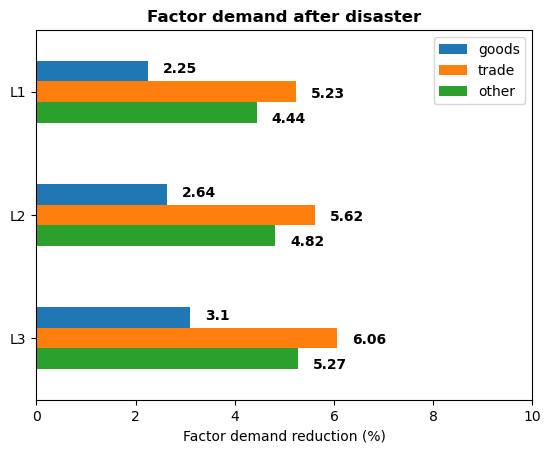

In [52]:
# Labor groups
data_pre = {"Sectors": ["L1", "L2", "L3"],
            "GOODS": [449.006038, 3282.049564, 3013.051661],
            "TRADE": [2729.055379, 4360.095686, 1851.044407],
            "OTHER": [6306.146353, 12396.308192, 5444.146479]}
pre_fd = pd.DataFrame(data_pre)
data_pos = {"Sectors": ["L1", "L2", "L3"],
            "GOODS": [438.913649, 3195.254485, 2919.538642],
            "TRADE": [2586.192593, 4115.076833, 1738.785852],
            "OTHER": [6026.389334, 11798.285962, 5157.077844]}
pos_fd = pd.DataFrame(data_pos)

perf_gd = (1 - pos_fd['GOODS'] / pre_fd['GOODS']) * 100  # percentage
perf_tr = (1 - pos_fd['TRADE'] / pre_fd['TRADE']) * 100
perf_ot = (1 - pos_fd['OTHER'] / pre_fd['OTHER']) * 100

# Labor groups
labor_groups = ('L1', 'L2', 'L3')
goods = perf_gd.values.round(2).tolist()
trade = perf_tr.values.round(2).tolist()
other = perf_ot.values.round(2).tolist()

y_pos_fd = np.arange(len(labor_groups))

plt.rcdefaults()
df_all = pd.DataFrame({'goods': goods, 'trade': trade, 'other': other}, index = labor_groups)
ax_fd = df_all.plot.barh(align='center')

for i, v in enumerate(round(perf_gd, 2)):
    ax_fd.text(v + 0.3, i - 0.15, str(v), color='black', fontweight='bold')
for i, v in enumerate(round(perf_tr, 2)):
    ax_fd.text(v + 0.3, i + 0.05, str(v), color='black', fontweight='bold')
for i, v in enumerate(round(perf_ot, 2)):
    ax_fd.text(v + 0.3, i + 0.25, str(v), color='black', fontweight='bold')
ax_fd.set_yticks(y_pos_fd)
ax_fd.set_yticklabels(labor_groups)
ax_fd.invert_yaxis()
ax_fd.set_xlabel('Factor demand reduction (%)')
ax_fd.set_title('Factor demand after disaster', fontsize=12, weight='bold')
plt.xlim(0, 10)
plt.show()

##### 5.2.3. Percent Reduction of Employment

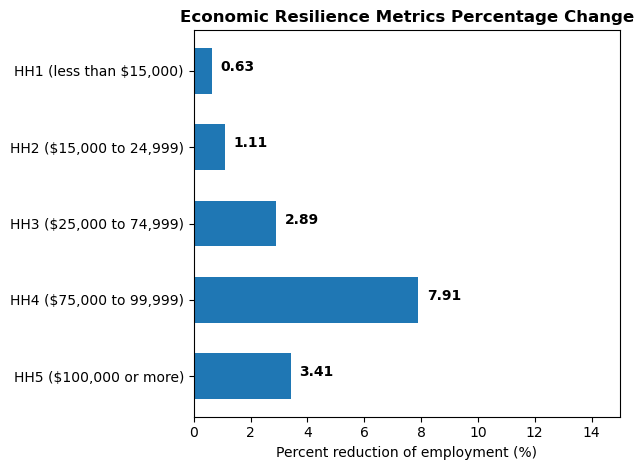

In [53]:
plt.rcdefaults()
fig_hc, ax_hc = plt.subplots()
household_hc = ('HH1 (less than $15,000)', 'HH2 ($15,000 to 24,999)', 'HH3 ($25,000 to 74,999)',
                'HH4 ($75,000 to 99,999)', 'HH5 ($100,000 or more)')
y_pos = np.arange(len(household_hc))
perf_hc = (1 - hc['HHL'] / hc['HH0']) * 100  # percentage

for i, v in enumerate(round(perf_hc, 2)):
    ax_hc.text(v + 0.3, i, str(v), color='black', fontweight='bold')
ax_hc.barh(y_pos, perf_hc, align='center', height=0.6)
ax_hc.set_yticks(y_pos)
ax_hc.set_yticklabels(household_hc)
ax_hc.invert_yaxis()
ax_hc.set_title('Economic Resilience Metrics Percentage Change', fontsize=12, weight='bold')
ax_hc.set_xlabel('Percent reduction of employment (%)')
plt.xlim(0, 15)
fig_hc.tight_layout()
plt.show()

### 6. Sociological Analysis

This section introduces the sociology-based analysis which may be integrated with hazard and building damage analysis. In this example the damage to buildings drives the population dislocation algorithm at the household level. 

#### 6.1. Population Dislocation Model

The population dislocation model depends first on the allocation of detailed housing unit and household characteristic data to each residential building within the community. The allocation of detailed household characteristic data provides an estimate of the number of people that live within each structure. The dislocation model is based on household surveys, for a more detailed summary of the dislocation model please refer to Rosenheim, Guidotti, Gardoni, and Peacock 2019.

The model predicts which households within the community will be dislocated from their homes immediately following the hazard event.

In [54]:
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil

In [55]:
housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
bg_data = "5d4c9545b9219c0689b2358a"
value_loss = "5dfd1069fc33d500081555d8"

In [56]:
# Create Population dislocation analysis
pop_dis = PopulationDislocation(client)

In [57]:
# Load analysis input datasets
pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_poss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)  # Load the Joplin building damage results dataset 
                                                                # generated from the previous model as an input

True

In [58]:
result_name = "pop-dislocation-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

True

In [59]:
pop_dis.run_analysis()

# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
df = result.get_dataframe_from_csv()
df.head()

/Users/mo/opt/miniconda3/envs/pyincore_app/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (0,5,6,7,11,12,13,55) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


,guid,insignific,moderate,heavy,complete,demandtype,demandunits,strctid,statefp10,tractce10,...,bgyear,pblackbg,phispbg,d_sf,rploss_ins,rploss_med,rploss_hwy,rploss_cmp,prdis,dislocated
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,1.0,0.0,0.0,0.0,Wind,mps,S0018614,29.0,11100.0,...,2010.0,2.235294,4.470588,0,0.002914,0.100425,0.524702,0.889881,0.374637,True
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,1.0,0.0,0.0,0.0,Wind,mps,S0018615,29.0,11100.0,...,2010.0,2.235294,4.470588,0,0.006930,0.132025,0.677548,0.951019,0.376972,False
2,758fb3de-108a-4e04-895e-fdc4b8627876,1.0,0.0,0.0,0.0,Wind,mps,S0018616,29.0,11100.0,...,NaN,NaN,NaN,0,0.005776,0.100000,0.654935,0.941974,NaN,False
3,7b706697-bf9b-4883-90f6-862d67a8e64b,1.0,0.0,0.0,0.0,Wind,mps,S0018617,29.0,11100.0,...,2010.0,2.235294,4.470588,0,0.002404,0.105851,0.436479,0.854591,0.374340,True
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,1.0,0.0,0.0,0.0,Wind,mps,S0018618,29.0,11100.0,...,2010.0,2.235294,4.470588,0,0.003029,0.133077,0.438777,0.855511,0.374703,True


#### 6.2. Sociological Resilience Metrics

##### 6.2.1. Percent of Population Dislocation

The PopulationDislocation model predicts the probability of dislocation using a logistic regression model based on household level surveys from Hurricane Andrew in 1992, which was a major wind event. The logistic regression equation provides a probability of dislocation based on the value loss and the other factors. For more details on the population dislocation algorithm and the logistic regression model see Rosenheim et al 2019. 

To determine if a household dislocate a random value was uniformly sampled between 0 and 1: if this value was lower than the probability of dislocation, then the household was set to dislocate. The results below provide one example of how the output can be explored by population subgroups. The model is designed to run as part of a larger Monte Carlo Simulation.

In [60]:
result = pop_dis.get_output_dataset("result")

df = result.get_dataframe_from_csv()
# Select Housing units allocated to buildings

/Users/mo/opt/miniconda3/envs/pyincore_app/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (0,5,6,7,11,12,13,55) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [61]:
table_title = "Total population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum,
            dropna=True, margins=True, margins_name="Total").style.set_caption(table_title)

dislocated,False,True,Total
ownershp,,,
1.0,104692.000000,12767.000000,117459.000000
2.0,44985.000000,8782.000000,53767.000000
Total,149677.000000,21549.000000,171226.000000


In [62]:
table_title = "Percent population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum, normalize='index',
            dropna=True, margins=True, margins_name="Total").round(4)*100

dislocated,False,True
ownershp,,
1.0,89.13,10.87
2.0,83.67,16.33
Total,87.41,12.59


The variable ownershp represents the tenure status of households. When ownershp = 1 the housing unit is owner-occupied. When the ownershp = 2 the housing unit is renter-occupied. 
The results above provide the percent of the population predicted to dislocate based on tenure status. When the variable dislocated = True the household is predicted to dislocate.

### 7. References

Attary, N., van de Lindt, J. W., Mahmoud, H., Smith, S., Navarro, C. M., Kim, Y. W., & Lee, J. S. (2018). Hindcasting community-level building damage for the 2011 Joplin EF5 tornado. Natural Hazards, 93(3), 1295-1316.

Attary, N., van de Lindt, J. W., Mahmoud, H., & Smith, S. (2018). Hindcasting Community-Level Damage to the Interdependent Buildings and Electric Power Network after the 2011 Joplin, Missouri, Tornado. Natural Hazards Review, 20(1), 04018027.

Memari, M., Attary, N., Masoomi, H., Mahmoud, H., van de Lindt, J. W., Pilkington, S. F., & Ameri, M. R. (2018). Minimal building fragility portfolio for damage assessment of communities subjected to tornadoes. Journal of Structural Engineering, 144(7), 04018072.

Guidotti, R., Gardoni, P., & Rosenheim, N. (2019). Integration of physical infrastructure and social systems in communities’ reliability and resilience analysis. Reliability Engineering & System Safety, 185, 476-492. https://doi.org/10.1016/j.ress.2019.01.008

Rosenheim, N., Guidotti, R., Gardoni, P., & Peacock, W. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. https://doi.org/10.1080/23789689.2019.1681821